In [10]:
import json

ROOT_DIR = "outputs_drac"
CSV_NAME = "sit_format.csv"
Y_MEAN_ALIASES = ["test/mean_episode_reward", "test/mean_reward"]


def find_run_csvs(root, csv_name):
    out = []
    for d, _, f in os.walk(root):
        if csv_name in f:
            out.append(os.path.join(d, csv_name))
    return sorted(out)


def infer_run_name(path, root):
    return os.path.relpath(os.path.dirname(path), root).replace("\\", "/")


def parse_tokens(run):
    if "baseline" in run:
        env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
        return {"algo": "vtrace", "drac": "baseline", "drac_val": 0.0, "env": env}
    m = re.search(r"final_([0-9]*\.?[0-9]+(?:[eE][+\-]?\d+)?)_", run)
    drac_val = float(m.group(1)) if m else np.nan
    env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
    algo = "vtrace" if run.startswith("vtrace") else None
    drac = "drac" if "_drac_" in run else None
    return {"algo": algo, "drac": drac, "drac_val": drac_val, "env": env}


def get_first_present(df, cols):
    for c in cols:
        if c in df.columns:
            return c
    return None


def compute_reward_max(s):
    x = pd.to_numeric(pd.Series(s), errors="coerce").dropna().values.astype(float)
    if x.size == 0:
        return np.nan
    return float(np.max(x))


def load_rows(root):
    rows = []
    for p in find_run_csvs(root, CSV_NAME):
        run = infer_run_name(p, root)
        t = parse_tokens(run)
        if t["algo"] != "vtrace":
            continue
        if t["env"] not in ("fruitbot", "chaser"):
            continue
        if t["drac"] not in ("drac", "baseline"):
            continue
        try:
            df = pd.read_csv(p)
        except:
            continue
        y = get_first_present(df, Y_MEAN_ALIASES)
        if not y or "training_time" not in df.columns:
            continue
        val = compute_reward_max(df[y])
        if np.isnan(val):
            continue
        tt = df["training_time"].dropna().values
        tt = float(np.mean(tt)) if len(tt) > 0 else np.nan
        rows.append({"env": t["env"], "drac": float(t["drac_val"]), "reward_max": val, "training_time": tt})
    return rows


def compute_time_stats(df):
    out = {}
    for env in ["chaser", "fruitbot"]:
        dfe = df[df["env"] == env]
        base = dfe[dfe["drac"] == 0.0]["training_time"].dropna().values
        drac = dfe[dfe["drac"] != 0.0]["training_time"].dropna().values
        if len(base) == 0 or len(drac) == 0:
            out[env] = None
            continue
        out[env] = {
            "baseline": float(np.mean(base)),
            "drac": float(np.mean(drac)),
            "ratio": float(np.mean(drac) / np.mean(base))
        }
    return out


def main():
    rows = load_rows(ROOT_DIR)
    if not rows:
        print("No runs found")
        return
    df = pd.DataFrame(rows)
    stats = compute_time_stats(df)
    print(json.dumps(stats, indent=2))


if __name__ == "__main__":
    main()


{
  "chaser": {
    "baseline": 983.8615916432803,
    "drac": 1442.3226926407767,
    "ratio": 1.4659812974625408
  },
  "fruitbot": {
    "baseline": 975.4920082631743,
    "drac": 1640.8664001165048,
    "ratio": 1.6820910742651842
  }
}


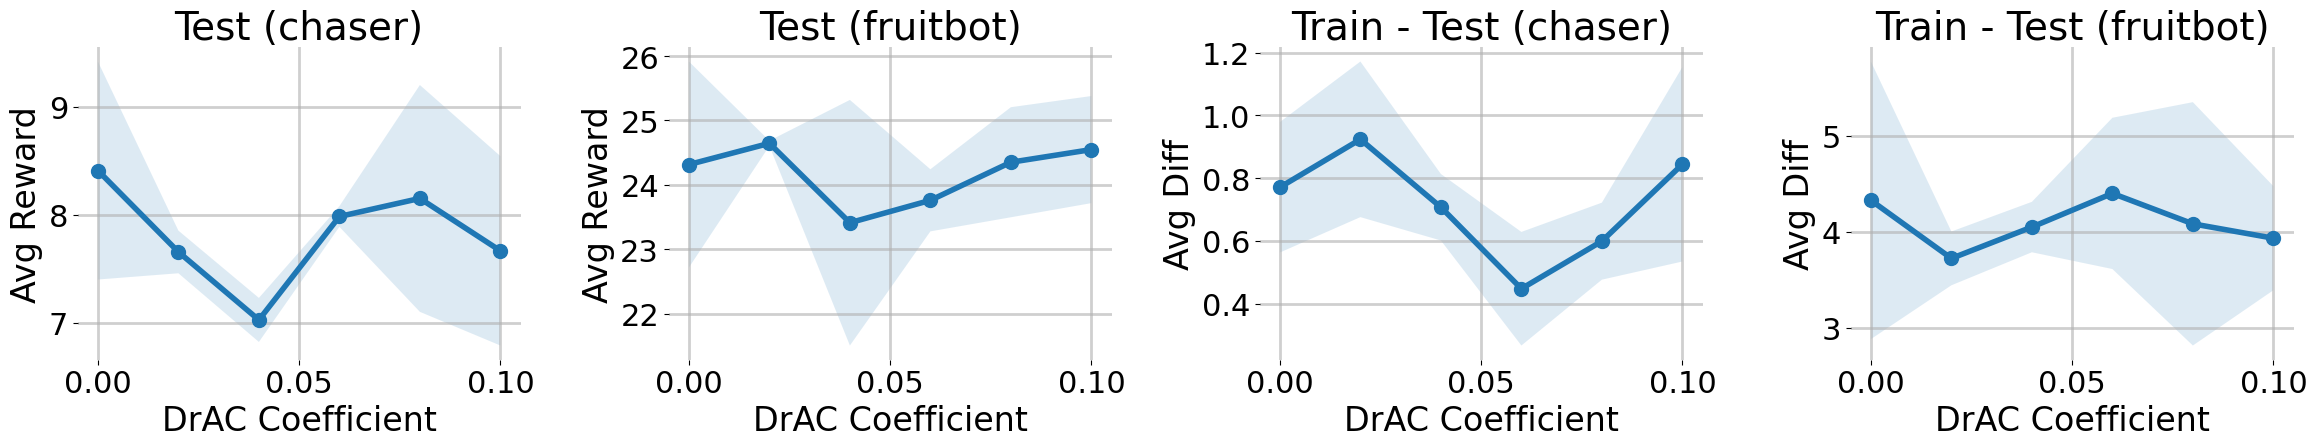

In [11]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 24,
    "axes.titlesize": 28,
    "axes.labelsize": 24,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 22,

    "lines.linewidth": 3.0,
    "lines.markersize": 10,
    "patch.linewidth": 2.0,
    "axes.linewidth": 2.0,
    "grid.linewidth": 1.8,
})

ROOT_DIR = "outputs_drac"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"
OUT_NAME_FOUR = "vtrace_drac_four_panel.png"

Y_TEST = ["test/mean_episode_reward", "test/mean_reward"]
Y_TRAIN = ["train/mean_episode_reward", "train/mean_reward"]
LAST_N_ROWS = 50


def find_run_csvs(root, csv_name):
    out = []
    for d, _, f in os.walk(root):
        if csv_name in f:
            out.append(os.path.join(d, csv_name))
    return sorted(out)


def infer_run_name(path, root):
    return os.path.relpath(os.path.dirname(path), root).replace("\\", "/")


def parse_tokens(run):
    if "baseline" in run:
        env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
        return {"algo": "vtrace", "drac": "baseline", "drac_val": 0.0, "env": env}

    m = re.search(r"final_([0-9]*\.?[0-9]+(?:[eE][+\-]?\d+)?)_", run)
    drac_val = float(m.group(1)) if m else np.nan

    env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
    algo = "vtrace" if run.startswith("vtrace") else None
    drac = "drac" if "_drac_" in run else None

    return {"algo": algo, "drac": drac, "drac_val": drac_val, "env": env}


def get_first_present(df, cols):
    for c in cols:
        if c in df.columns:
            return c
    return None


def load_rows(root):
    rows = []

    for p in find_run_csvs(root, CSV_NAME):
        run = infer_run_name(p, root)
        t = parse_tokens(run)

        if t["algo"] != "vtrace":
            continue
        if t["env"] not in ("fruitbot", "chaser"):
            continue
        if t["drac"] not in ("drac", "baseline"):
            continue

        try:
            df = pd.read_csv(p)
        except:
            continue

        df_last = df.tail(LAST_N_ROWS)

        test_col = get_first_present(df_last, Y_TEST)
        train_col = get_first_present(df_last, Y_TRAIN)

        if test_col:
            v = pd.to_numeric(df_last[test_col], errors="coerce").dropna().values
            if v.size > 0:
                rows.append({"run": run, "env": t["env"], "drac": float(t["drac_val"]),
                             "kind": "test", "reward": float(np.mean(v))})

        if train_col:
            v = pd.to_numeric(df_last[train_col], errors="coerce").dropna().values
            if v.size > 0:
                rows.append({"run": run, "env": t["env"], "drac": float(t["drac_val"]),
                             "kind": "train", "reward": float(np.mean(v))})

    return rows


def compute_differences(df):
    df_t = df[df["kind"] == "test"][["run", "env", "drac", "reward"]]
    df_r = df[df["kind"] == "train"][["run", "env", "drac", "reward"]]

    m = pd.merge(df_t, df_r, on=["run", "env", "drac"], suffixes=("_test", "_train"))
    m["diff"] = m["reward_train"] - m["reward_test"]
    return m


def plot_env(ax, df_env, title, ylabel):
    if df_env.empty:
        ax.set_visible(False)
        return

    dfg = df_env.groupby("drac")
    xs, means, lowers, uppers = [], [], [], []

    for drac, g in dfg:
        vals = g.iloc[:, -1].dropna().values
        mu = float(np.mean(vals))
        se = float(np.std(vals) / np.sqrt(len(vals)))

        xs.append(drac)
        means.append(mu)
        lowers.append(mu - 1.96 * se)
        uppers.append(mu + 1.96 * se)

    xs = np.array(xs)
    order = np.argsort(xs)
    xs = xs[order]
    means = np.array(means)[order]
    lowers = np.array(lowers)[order]
    uppers = np.array(uppers)[order]

    ax.plot(xs, means, marker="o", linewidth=4)
    ax.fill_between(xs, lowers, uppers, alpha=0.15)
    ax.set_title(title)
    ax.set_xlabel("DrAC Coefficient")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="-", linewidth=2, alpha=0.6)

    for s in ax.spines.values():
        s.set_visible(False)


def plot_four(df_chaser_test, df_fruitbot_test,
              df_chaser_diff, df_fruitbot_diff,
              out_dir, filename):
    fig, axs = plt.subplots(1, 4, figsize=(24, 5))

    plot_env(axs[0], df_chaser_test, "Test (chaser)", "Avg Reward")
    plot_env(axs[1], df_fruitbot_test, "Test (fruitbot)", "Avg Reward")
    plot_env(axs[2], df_chaser_diff, "Train - Test (chaser)", "Avg Diff")
    plot_env(axs[3], df_fruitbot_diff, "Train - Test (fruitbot)", "Avg Diff")

    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, filename), bbox_inches="tight")
    plt.show()
    plt.close()


def main():
    rows = load_rows(ROOT_DIR)
    if not rows:
        print("No runs found")
        return

    df = pd.DataFrame(rows)

    df_test = df[df["kind"] == "test"]
    df_train = df[df["kind"] == "train"]

    diff = compute_differences(df)

    df_chaser_test = df_test[df_test["env"] == "chaser"]
    df_fruitbot_test = df_test[df_test["env"] == "fruitbot"]

    df_chaser_diff = diff[diff["env"] == "chaser"]
    df_fruitbot_diff = diff[diff["env"] == "fruitbot"]

    plot_four(df_chaser_test, df_fruitbot_test,
              df_chaser_diff, df_fruitbot_diff,
              PLOTS_DIR, OUT_NAME_FOUR)


if __name__ == "__main__":
    main()
